# Appendix
## Implementation Universal thresholding

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pywt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import pandas as pd
from measure import compute_psnr, compute_ssim
from utils import add_noisy, transform_wavelet

In [2]:
_IMG_PATH = '../images/lena512.bmp'

In [3]:
img = cv2.imread(_IMG_PATH)
# img.shape

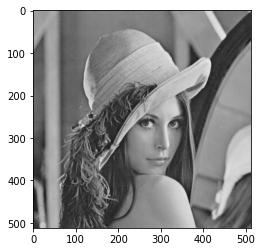

In [4]:
plt.imshow(img)

In [5]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_origin = img_gray

In [6]:
img_noise, noise = add_noisy(img_gray, var=50**2)

In [7]:
y_coeffs = transform_wavelet(img_noise)
x_coeffs = transform_wavelet(img_gray)
v_coeffs = transform_wavelet(noise)

In [8]:
var_noise_est = np.median(np.abs(y_coeffs[-1][-1]))/0.6745

(-0.5, 256.5, 256.5, -0.5)

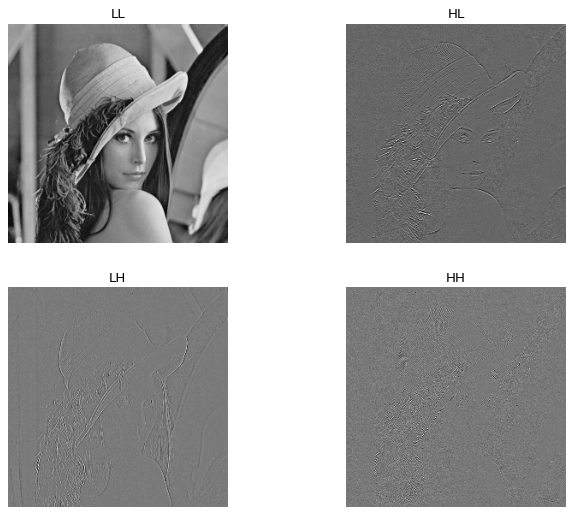

In [15]:
plt.figure(figsize=(10, 8), dpi=80)

plt.subplot(2, 2, 1)
plt.imshow(x_coeffs[0],cmap='gray')
plt.title("LL")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(x_coeffs[1][0],cmap='gray')
plt.title("HL")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(x_coeffs[1][1],cmap='gray')
plt.title("LH")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(x_coeffs[1][2],cmap='gray')
plt.title("HH")
plt.axis('off')

# plt.savefig('../outputs/wavelet_coef.png')


C:\Users\Admin\anaconda3\envs\vision\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


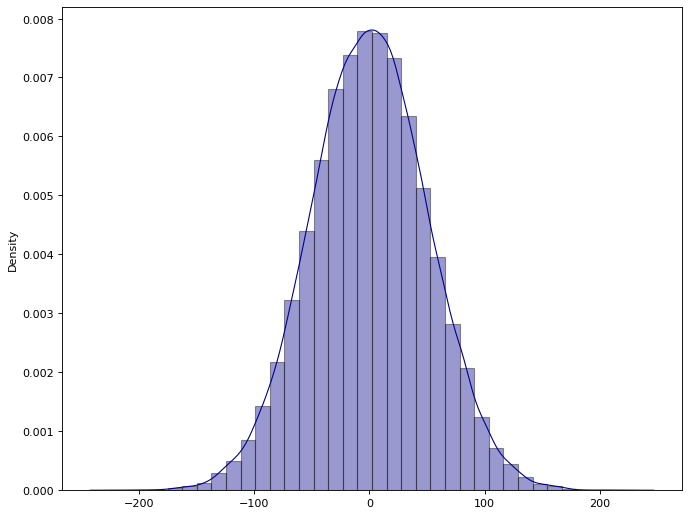

In [16]:
plt.figure(figsize=(10, 8), dpi=80)

fig = sns.distplot(y_coeffs[1][2].flatten(), hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1}).get_figure()

# fig.savefig('../outputs/dist_hh.png')

In [11]:
def universal_denoising(img_origin, img_noise, var_noise_est):
    threshold = var_noise_est*np.sqrt(2*np.log(img_noise.size))
    ll, (hl, lh, hh) = y_coeffs
    hl_thres = pywt.threshold(hl, threshold, mode='soft')
    lh_thres = pywt.threshold(lh, threshold, mode='soft')
    hh_thres = pywt.threshold(hh, threshold, mode='soft')
    coef_thres = ll, (hl_thres, lh_thres, hh_thres)
    img_denoise = pywt.waverec2(coef_thres, 'db2')

    psnr = compute_psnr(img_origin, img_noise),compute_psnr(img_origin, img_denoise)
    
    return img_denoise, psnr

In [12]:
img_denoise, psnr = universal_denoising(img_origin, img_noise, var_noise_est)

In [13]:
psnr

(14.121518213254111, 19.973484675859826)

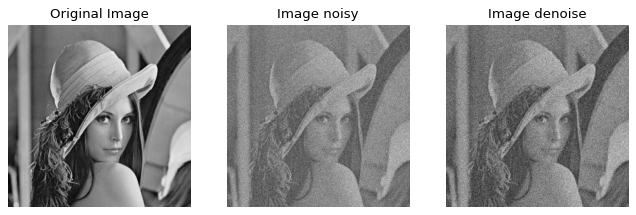

In [14]:
plt.figure(figsize=(10, 8), dpi=80)

plt.subplot(1, 3, 1)
plt.imshow(img_gray,cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_noise,cmap='gray')
plt.title("Image noisy")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_denoise,cmap='gray')
plt.title("Image denoise")
plt.axis('off')

plt.savefig('../outputs/soft_threshold_var_50.png')